# Model 2: vgg16

## 1 Imports

In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import cv2


In [2]:
dir = '../../Data/Splitted_Images/'

train_dataset = image_dataset_from_directory(
    os.path.join(dir, "train"),
    image_size=(170, 256),
    batch_size=128)
validation_dataset = image_dataset_from_directory(
    os.path.join(dir, "val"),
    image_size=(170, 256),
    batch_size=128)
test_dataset = image_dataset_from_directory(
    os.path.join(dir, "test"),
    image_size=(170, 256),
    batch_size=128)

Found 3500 files belonging to 5 classes.
Found 750 files belonging to 5 classes.
Found 750 files belonging to 5 classes.


## 3 Training the model

In [3]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])


inputs = keras.Input(shape=(170, 256, 3))
x = data_augmentation(inputs) 
x = layers.Dropout(0.2)(x)
x = keras.applications.vgg16.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 170, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 170, 256, 3)       0         
                                                                 
 dropout (Dropout)           (None, 170, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 170, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 170, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                             

In [6]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/2_VGG16_Model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor='val_loss', mode='auto', patience=5)  
    ]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
28/28 [==============================] - 48s 1s/step - loss: 8.9286 - accuracy: 0.3314 - val_loss: 2.4231 - val_accuracy: 0.5280
Epoch 2/50
28/28 [==============================] - 21s 744ms/step - loss: 3.4337 - accuracy: 0.4166 - val_loss: 1.4474 - val_accuracy: 0.6147
Epoch 3/50
28/28 [==============================] - 21s 744ms/step - loss: 2.0594 - accuracy: 0.4949 - val_loss: 1.2014 - val_accuracy: 0.6533
Epoch 4/50
28/28 [==============================] - 21s 746ms/step - loss: 1.5211 - accuracy: 0.5383 - val_loss: 0.9898 - val_accuracy: 0.6787
Epoch 5/50
28/28 [==============================] - 21s 748ms/step - loss: 1.2564 - accuracy: 0.5820 - val_loss: 0.8939 - val_accuracy: 0.6947
Epoch 6/50
28/28 [==============================] - 21s 749ms/step - loss: 1.0173 - accuracy: 0.6406 - val_loss: 0.8045 - val_accuracy: 0.7187
Epoch 7/50
28/28 [==============================] - 21s 748ms/step - loss: 0.8968 - accuracy: 0.6783 - val_loss: 0.7994 - val_accuracy: 0.7373
Ep

## 4 Plotting the training result

In [16]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

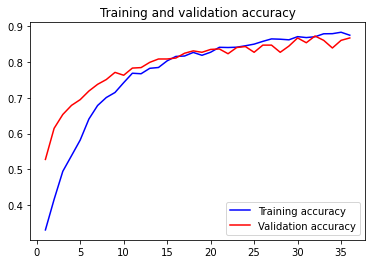

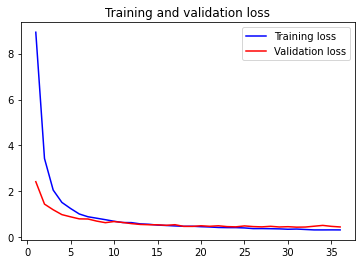

In [17]:
plot_function(history)

## 5 Testing the model on the testset

In [18]:
test_model = keras.models.load_model("models/2_VGG16_Model.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 4s 556ms/step - loss: 0.3877 - accuracy: 0.8560
Test accuracy: 0.856
